Device 0: Microsoft Sound Mapper - Input
Found an input: device 0 - Microsoft Sound Mapper - Input
4635.02197266 ( D8 = 4698.63628668 )
72.6745605469 ( D2 = 73.4161919794 )
72.6745605469 ( D2 = 73.4161919794 )
72.6745605469 ( D2 = 73.4161919794 )
707.904052734 ( F5 = 698.456462866 )
769.812011719 ( G5 = 783.990871963 )
1146.64306641 ( D6 = 1174.65907167 )
745.587158203 ( F#5 = 739.988845423 )
69.9829101563 ( C#2 = 69.2956577442 )
34.9914550781 ( A1 = 55.0 )
713.287353516 ( F5 = 698.456462866 )
707.904052734 ( F5 = 698.456462866 )
791.345214844 ( G5 = 783.990871963 )
796.728515625 ( G5 = 783.990871963 )
783.270263672 ( G5 = 783.990871963 )
783.270263672 ( G5 = 783.990871963 )
796.728515625 ( G5 = 783.990871963 )
767.120361328 ( G5 = 783.990871963 )
659.454345703 ( E5 = 659.255113826 )
775.1953125 ( G5 = 783.990871963 )
788.653564453 ( G5 = 783.990871963 )
823.645019531 ( G#5 = 830.60939516 )
791.345214844 ( G5 = 783.990871963 )
794.036865234 ( G5 = 783.990871963 )
1068.58520508 ( C6 = 1

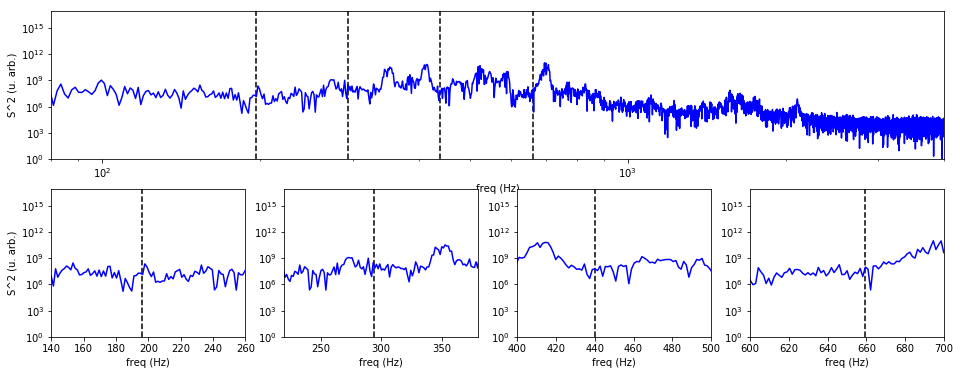

In [1]:
import pyaudio
import struct
import numpy as np
import matplotlib.pyplot as plt
from time import sleep


CHUNK = 2**14 #2**15 #4096
WIDTH = 2
FORMAT = pyaudio.paInt16 
CHANNELS = 2
RATE = 44100
dt = 1.0/RATE


### frequencies of the strings for the violin (tunned in A), in Hz
f4 = 195.998   ## G3
f3 = 293.665   ## D4
f2 = 440.000   ## A4
f1 = 659.255   ## E5

n = CHUNK
freqs = np.fft.rfftfreq(n, d = dt)

def Frequency_of_position(position):
    """ Returns the frequency (Hz) of the note in from its position (halftones)
    relative to A4 in an equal tempered scale. Ex: 0 -> 440 Hz (A4), 
    12 -> 880 Hz (A5)."""
    return 440.0*(2**(1.0/12.0))**position


def Position_to_note(position):
    "A A# B C C# D D# E F F# G G#"
    SCALE = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
    LETTER = SCALE[position % 12]
    NUMBER = str(int((position+57) / 12))
    return LETTER+NUMBER

pos = np.array(range(-36,48))
vnote_freqs = np.vectorize(Frequency_of_position)
note_freqs = vnote_freqs(pos)


def get_frequency( spectrum ):
    return freqs[np.argmax(spectrum)]



class Freq_analysis(object):
    def __init__(self):
        self.pa = pyaudio.PyAudio()
        self.stream = self.open_mic_stream()
        self.plots = self.prepare_figure()
        #self.fig_and_axes = self.prepare_figure()
        #self.first_plot = self.plot_first_figure()


    def stop(self):
        self.stream.close()

    def open_mic_stream( self ):
        device_index = self.find_input_device()

        stream = self.pa.open(   format = FORMAT,
                                 channels = CHANNELS,
                                 rate = RATE,
                                 input = True,
                                 input_device_index = device_index,
                                 frames_per_buffer = CHUNK)

        return stream

    def find_input_device(self):
        device_index = None            
        for i in range( self.pa.get_device_count() ):     
            devinfo = self.pa.get_device_info_by_index(i)   
            print( "Device %d: %s"%(i,devinfo["name"]) )

            for keyword in ["mic","input"]:
                if keyword in devinfo["name"].lower():
                    print( "Found an input: device %d - %s"%    (i,devinfo["name"]) )
                    device_index = i
                    return device_index

        if device_index == None:
            print( "No preferred input found; using default input device." )

        return device_index

    def prepare_figure(self):
        plt.ion()
        fig1 = plt.figure(1, figsize = (16,6))
        wide_plot = plt.subplot(2,1,1)
        plt.vlines([f1,f2,f3,f4],1,1e17, linestyles = 'dashed')
        plt.xlabel("freq (Hz)")
        plt.ylabel("S^2 (u. arb.)")
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim([80,4000])
        #plt.xlim([600,700])
        #plt.xlim([400,500])
        plt.ylim([1e0,1e17])
        spec_w, = plt.plot([1,1],[1,1], '-',c = 'blue')

        f4_plot = plt.subplot(2,4,5)
        plt.vlines(f4,1,1e17, linestyles = 'dashed')
        plt.xlabel("freq (Hz)")
        plt.ylabel("S^2 (u. arb.)")
        plt.yscale('log')
        plt.xlim([140,260])
        plt.ylim([1e0,1e17])
        spec_f4, = plt.plot([1,1],[1,1], '-',c = 'blue')

        f3_plot = plt.subplot(2,4,6)
        plt.vlines(f3,1,1e17, linestyles = 'dashed')
        plt.xlabel("freq (Hz)")
        plt.yscale('log')
        plt.xlim([220,380])
        plt.ylim([1e0,1e17])
        spec_f3, = plt.plot([1,1],[1,1], '-',c = 'blue')

        f2_plot = plt.subplot(2,4,7)
        plt.vlines(f2,1,1e17, linestyles = 'dashed')
        plt.xlabel("freq (Hz)")
        plt.yscale('log')
        plt.xlim([400,500])
        plt.ylim([1e0,1e17])
        spec_f2, = plt.plot([1,1],[1,1], '-',c = 'blue')

        f1_plot = plt.subplot(2,4,8)
        plt.vlines(f1,1,1e17, linestyles = 'dashed')
        plt.xlabel("freq (Hz)")
        plt.yscale('log')
        plt.xlim([600,700])
        plt.ylim([1e0,1e17])
        spec_f1, = plt.plot([1,1],[1,1], '-',c = 'blue')

        plt.draw()

    #return fig1, wide_plot, f1_plot, f2_plot, f3_plot, f4_plot
        return spec_w, spec_f1, spec_f2, spec_f3, spec_f4


    def PrintFreq(self, S2):
        dominant = get_frequency( S2 )
        dist = np.abs(note_freqs-dominant)
        closest_pos = pos[np.argmin(dist)]
        closest_note = Position_to_note(closest_pos)
        print(dominant, "(",closest_note, "=",Frequency_of_position(closest_pos),")")

    def listen(self):
        try:
            block = self.stream.read(CHUNK)
        except IOError:
            # An error occurred. 
            print( "Error recording.")
            return
        indata = np.array(struct.unpack("%dh"%(len(block)/2),block))
        n = indata.size
        freqs = np.fft.rfftfreq(n, d = dt)
        data_rfft = np.fft.rfft(indata)
        S2 = np.abs(data_rfft)**2
        #self.PrintFreq(block)
        #self.update_fig(block)
        self.PrintFreq(S2)
        self.update_fig(freqs, S2)

    def update_fig(self, freqs, S2):
        self.plots[0].set_xdata(freqs)
        self.plots[1].set_xdata(freqs)
        self.plots[2].set_xdata(freqs)
        self.plots[3].set_xdata(freqs)
        self.plots[4].set_xdata(freqs)

        self.plots[0].set_ydata(S2)
        self.plots[1].set_ydata(S2)
        self.plots[2].set_ydata(S2)
        self.plots[3].set_ydata(S2)
        self.plots[4].set_ydata(S2)
        plt.draw()
        plt.pause(0.001)


if __name__ == "__main__":
    Tuner = Freq_analysis()

    for i in range(100):
        Tuner.listen()
    plt.ioff()
    plt.show()